# Imports

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load Data

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [3]:
[item.shape for item in (X_train, y_train, X_test, y_test)]    

[(50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1)]

# Preview

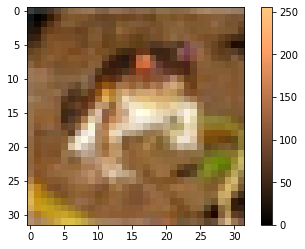

In [4]:
plt.imshow(X_train[0], cmap='copper')
plt.colorbar()

The values of X range from 0 to 255, we need to scale it down to 0 to 1.0 for best result.

In [5]:
y_train

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

We need to convert y label to one-hot encoding before we can use neural network as model.

# Preprocessing

In [6]:
X_train, X_test = X_train/255, X_test/255

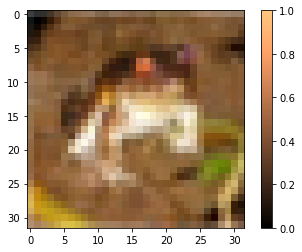

In [7]:
plt.imshow(X_train[0], cmap='copper')
plt.colorbar()

In [8]:
y_train, y_test = (tf.keras.utils.to_categorical(y) for y in (y_train, y_test))

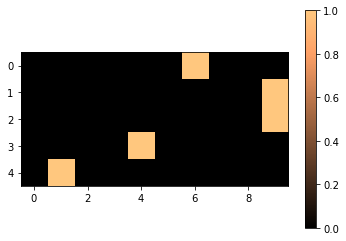

In [9]:
plt.imshow(y_train[:5], cmap='copper')
plt.colorbar()

Now each X input is a 32x32x3 array with values between 0 and 1 and each y label is a one-hot encoded vector.

# Model

Since the inputs are images, and the task is to classify them, convolution neural network seems to be a suitable model.

In [10]:
input_shape = X_train.shape[1:]
num_classes = y_train.shape[1]

In [11]:
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    Flatten(), 
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax'),    
])

In [12]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

In [13]:
if os.path.isfile('model.h5'):
    model = tf.keras.models.load_model('model.h5')
    print('Load model successfully')

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0

In [15]:
history = model.fit(X_train, y_train,
                    batch_size=256,
                    epochs=1000,
                    validation_split = 0.2,
                    callbacks=[
                        EarlyStopping(monitor='val_accuracy', patience=20)
                    ])

Epoch 1/1000
157/157 [==============================] - 2s 10ms/step - loss: 1.8133 - accuracy: 0.3284 - val_loss: 1.5454 - val_accuracy: 0.4460
Epoch 2/1000
157/157 [==============================] - 1s 7ms/step - loss: 1.4522 - accuracy: 0.4698 - val_loss: 1.3312 - val_accuracy: 0.5259
Epoch 3/1000
157/157 [==============================] - 1s 8ms/step - loss: 1.3279 - accuracy: 0.5265 - val_loss: 1.2835 - val_accuracy: 0.5456
Epoch 4/1000
157/157 [==============================] - 1s 7ms/step - loss: 1.2243 - accuracy: 0.5638 - val_loss: 1.1749 - val_accuracy: 0.5858
Epoch 5/1000
157/157 [==============================] - 1s 7ms/step - loss: 1.1618 - accuracy: 0.5879 - val_loss: 1.1651 - val_accuracy: 0.5911
Epoch 6/1000
157/157 [==============================] - 1s 8ms/step - loss: 1.0982 - accuracy: 0.6127 - val_loss: 1.0738 - val_accuracy: 0.6261
Epoch 7/1000
157/157 [==============================] - 1s 7ms/step - loss: 1.0469 - accuracy: 0.6310 - val_loss: 1.0207 - val_accuracy

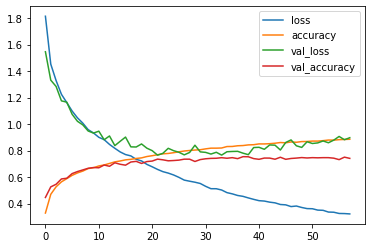

In [16]:
pd.DataFrame(history.history).plot()

In [17]:
model.save('model.h5')

# Evaluation

In [18]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=128)
print(f'Test loss: {test_loss:.6f}, Test acc: {test_accuracy:.2%}')

79/79 [==============================] - 0s 3ms/step - loss: 0.9233 - accuracy: 0.7294
Test loss: 0.923336, Test acc: 72.94%


In [19]:
y_test_pred = model.predict(X_test)

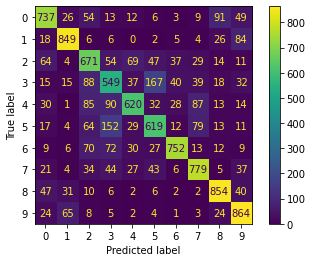

In [20]:
cmat = confusion_matrix(
    y_true=y_test.argmax(axis=1), 
    y_pred=y_test_pred.argmax(axis=1))
ConfusionMatrixDisplay(cmat).plot()

# Application

In [21]:
def application(idx=None):
    if not idx:
        idx = np.random.randint(len(X_test))
    print('Collected new features as follows:')
    plt.imshow(X_test[idx])
    plt.show()
    names = ['airplane','automobile','bird','cat','deer',
                   'dog','frog','horse','ship','truck']
    forecasted = model.predict(X_test[idx:idx+1]).argmax()
    actual = y_test[idx].argmax()
    print(f'\n{"CORRECT" if forecasted==actual else "WRONG"}')
    print(f'\nModel forecasted as {forecasted} ({names[forecasted]})')
    print(f'\nActual data should be {actual} ({names[actual]})')

Collected new features as follows:


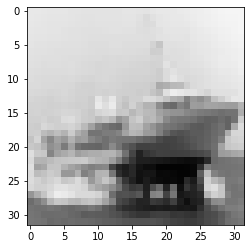


CORRECT

Model forecasted as 8 (ship)

Actual data should be 8 (ship)


In [22]:
application()